# Ecosystems Group
March 2019 OOI Data Labs Workshop

**Working Title**: Ecosystem Structure 

**Data Goals**
* Would like to show representative profiles of Oxygen, Light, and Chlorophyll for a time at each location when Chlorphyll is high.
* Ideally one would be from:
  * an open basin, e.g. from a glider at Papa (unfortunately, the Apex profiler only starts at 200m and doesn't include PAR)
  * another above a vent, e.g. [RS01SBPS](https://datareview.marine.rutgers.edu/sites/view/RS01SBPS), 
  * and another from nearshore, e.g. [CE04OSPS](https://datareview.marine.rutgers.edu/sites/view/CE04OSPS) or Coastal Pioneer.

Because we are interested in "light" data, we can limit the sites we are interesetd in to those that have a [PAR](https://datareview.marine.rutgers.edu/instrument-classes/view/PARAD) sensor.

See also these [processed FLORT datasets](https://github.com/ooi-data-review/2018-data-workshops/tree/master/biology/examples/extras/FLORT), which include data from the start of collection to spring 2018.
* oregon_slope_profiler RS01SBPS-SF01A-3A-FLORTD101
* axial_shallow_profiler RS03AXPS-SF03A-3A-FLORTD301
* oregon_offshore_profiler CE04OSPS-SF01B-3A-FLORTD104

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import pickle as pk
import gc
import pandas as pd
!pip install cmocean
import cmocean
import numpy as np

## Request Data from OOINet

In [0]:
def request_data(reference_designator,method,stream,start_date,end_date):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'beginDT':start_date,
    'endDT':end_date,
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

## Process the Datasets

In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  # ds = ds.chunk({'time': 100}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

## Global Papa Glider - This is the only GP glider deployment with PAR and DO
  * GP05MOAS-PG575-02-DOSTAM000
  * GP05MOAS-PG575-06-PARADM000
  * GP05MOAS-PG575-03-FLORTM000

In [0]:
# request_data('GP05MOAS-PG575-02-DOSTAM000','recovered_host','dosta_abcdjm_glider_recovered','','')
# request_data('GP05MOAS-PG575-06-PARADM000','recovered_host','parad_m_glider_recovered','','')
# request_data('GP05MOAS-PG575-03-FLORTM000','recovered_host','flort_m_sample','','')

In [0]:
url_gp05_do = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T170202-GP05MOAS-PG575-02-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/catalog.html'
url_gp05_par = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T172147-GP05MOAS-PG575-06-PARADM000-recovered_host-parad_m_glider_recovered/catalog.html'
url_gp05_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T172155-GP05MOAS-PG575-03-FLORTM000-recovered_host-flort_m_sample/catalog.html'

In [0]:
data_do = get_data(url_gp05_do,'CTDGV')#.to_dataframe()
data_do = data_do.where(data_do.practical_salinity>0)
data_par = get_data(url_gp05_par,'CTDGV')#.to_dataframe()
data_flo = get_data(url_gp05_flo,'CTDGV')

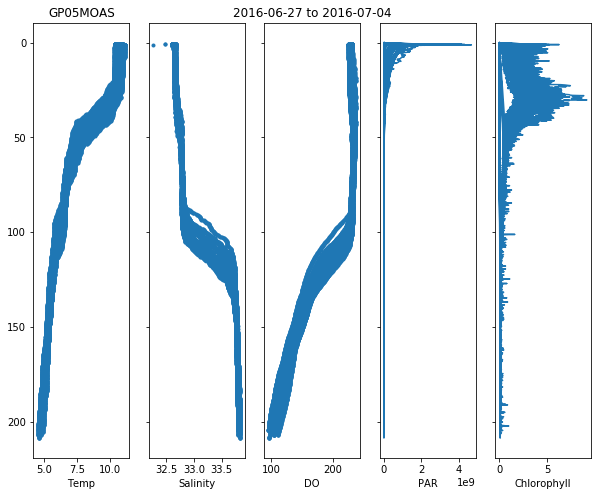

In [8]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, sharex=False, sharey=True)
fig.set_size_inches(10,8)

ax1.plot(data_do.sci_water_temp,data_do.int_ctd_pressure,'.')
ax2.plot(data_do.practical_salinity,data_do.int_ctd_pressure,'.')
ax3.plot(data_do.sci_abs_oxygen,data_do.int_ctd_pressure,'.')
ax4.plot(data_par.parad_m_par,data_par.int_ctd_pressure)
ax5.plot(data_flo.sci_flbbcd_chlor_units,data_flo.int_ctd_pressure)

ax1.invert_yaxis()

ax1.set_xlabel('Temp')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('DO')
ax4.set_xlabel('PAR')
ax5.set_xlabel('Chlorophyll')

ax1.set_title(data_do.subsite);
ax3.set_title('%s to %s' % (np.datetime_as_string(data_do.time.min().values,unit='D'),
                            np.datetime_as_string(data_do.time.max().values,unit='D')));
plt.savefig('%s.png' % (data_do.subsite))

## CP02PMCO Pioneer Central Offshore Profiler Mooring (148m)
* CP02PMCO-WFP01-02-DOFSTK000
* CP02PMCO-WFP01-05-PARADK000
* CP02PMCO-WFP01-04-FLORTK000

In [0]:
# Data Requests
# request_data('CP02PMCO-WFP01-02-DOFSTK000','recovered_wfp','dofst_k_wfp_instrument_recovered','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')
# request_data('CP02PMCO-WFP01-05-PARADK000','recovered_wfp','parad_k__stc_imodem_instrument_recovered','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')
# request_data('CP02PMCO-WFP01-04-FLORTK000','recovered_wfp','flort_sample','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')


In [0]:
# 2-Days
url_cp02_do = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T185559-CP02PMCO-WFP01-02-DOFSTK000-recovered_wfp-dofst_k_wfp_instrument_recovered/catalog.html'
url_cp02_par = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T185611-CP02PMCO-WFP01-05-PARADK000-recovered_wfp-parad_k__stc_imodem_instrument_recovered/catalog.html'
url_cp02_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T185622-CP02PMCO-WFP01-04-FLORTK000-recovered_wfp-flort_sample/catalog.html'

In [0]:
data_do = get_data(url_cp02_do,'CTDPF')
data_par = get_data(url_cp02_par,'CTDPF')
data_flo = get_data(url_cp02_flo,'CTDPF')

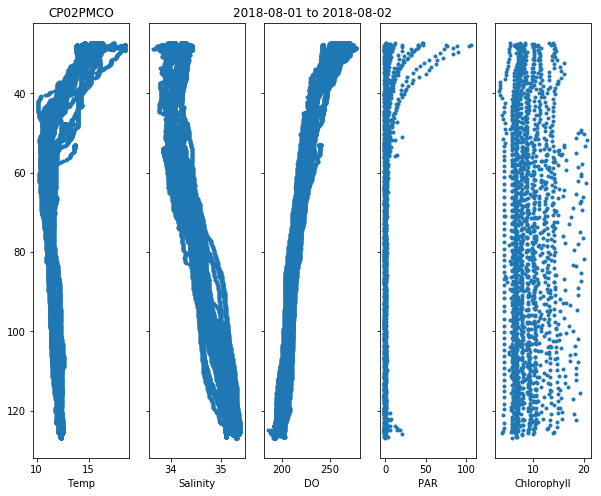

In [11]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, sharex=False, sharey=True)
fig.set_size_inches(10,8)

ax1.plot(data_do.ctdpf_ckl_seawater_temperature,data_do.int_ctd_pressure,'.')
ax2.plot(data_do.practical_salinity,data_do.int_ctd_pressure,'.')
ax3.plot(data_do.dofst_k_oxygen_l2,data_do.int_ctd_pressure,'.')
ax4.plot(data_par.parad_k_par,data_par.int_ctd_pressure,'.')
ax5.plot(data_flo.fluorometric_chlorophyll_a,data_flo.int_ctd_pressure,'.')

ax1.invert_yaxis()

ax1.set_xlabel('Temp')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('DO')
ax4.set_xlabel('PAR')
ax5.set_xlabel('Chlorophyll')

ax1.set_title(data_do.subsite);
ax3.set_title('%s to %s' % (np.datetime_as_string(data_do.time.min().values,unit='D'),
                            np.datetime_as_string(data_do.time.max().values,unit='D')));
plt.savefig('%s.png' % (data_do.subsite))

## Oregon Slope Base Shallow Profiler Mooring (2,906m)
* RS01SBPS-SF01A-2A-CTDPFA102
* RS01SBPS-SF01A-3C-PARADA101
* RS01SBPS-SF01A-3A-FLORTD101

In [0]:
# Data Requests
# request_data('RS01SBPS-SF01A-2A-CTDPFA102','streamed','ctdpf_sbe43_sample','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')
# request_data('RS01SBPS-SF01A-3C-PARADA101','streamed','parad_sa_sample','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')
# request_data('RS01SBPS-SF01A-3A-FLORTD101','streamed','flort_d_data_record','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')


In [0]:
# Data URLs
# July
# url_rs01_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T190130-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'
# url_rs01_par = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T190209-RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample/catalog.html'
# url_rs01_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T190217-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html'

# August
url_rs01_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T185649-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'
url_rs01_par = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T185750-RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample/catalog.html'
url_rs01_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T185729-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html'


In [0]:
data_do = get_data(url_rs01_ctd,'')
data_par = get_data(url_rs01_par,'CTDPF')
data_flo = get_data(url_rs01_flo,'CTDPF')

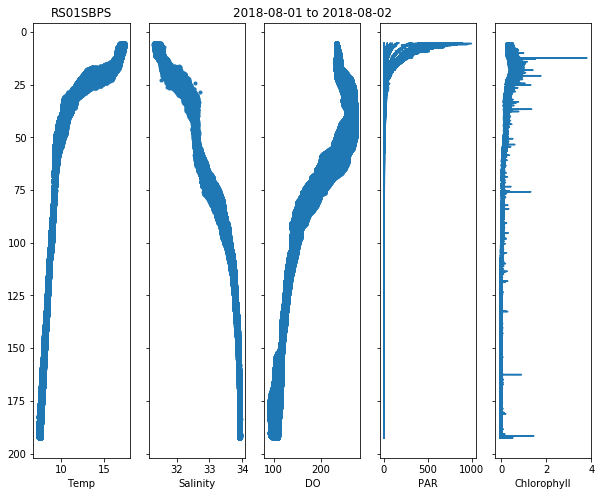

In [14]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, sharex=False, sharey=True)
fig.set_size_inches(10,8)

ax1.plot(data_do.seawater_temperature,data_do.seawater_pressure,'.')
ax2.plot(data_do.practical_salinity,data_do.seawater_pressure,'.')
ax3.plot(data_do.corrected_dissolved_oxygen,data_do.seawater_pressure,'.')
ax4.plot(data_par.par_counts_output,data_par.int_ctd_pressure)
ax5.plot(data_flo.fluorometric_chlorophyll_a,data_flo.int_ctd_pressure)

ax1.invert_yaxis()

ax1.set_xlabel('Temp')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('DO')
ax4.set_xlabel('PAR')
ax5.set_xlabel('Chlorophyll')

ax1.set_title(data_do.subsite);
ax3.set_title('%s to %s' % (np.datetime_as_string(data_do.time.min().values,unit='D'),
                            np.datetime_as_string(data_do.time.max().values,unit='D')));
plt.savefig('%s.png' % (data_do.subsite))

## Oregon Offshore Cabled Shallow Profiler Mooring (588m)
* CE04OSPS-SF01B-2A-CTDPFA107
* CE04OSPS-SF01B-3C-PARADA102	
* CE04OSPS-SF01B-3A-FLORTD104

In [0]:
# Data Requests
# request_data('CE04OSPS-SF01B-2A-CTDPFA107','streamed','ctdpf_sbe43_sample','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')
# request_data('CE04OSPS-SF01B-3C-PARADA102','streamed','parad_sa_sample','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')
# request_data('CE04OSPS-SF01B-3A-FLORTD104','streamed','flort_d_data_record','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')


In [0]:
# Data URLs
url_ce04_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T190645-CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample/catalog.html'
url_ce04_par = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T190657-CE04OSPS-SF01B-3C-PARADA102-streamed-parad_sa_sample/catalog.html'
url_ce04_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T190704-CE04OSPS-SF01B-3A-FLORTD104-streamed-flort_d_data_record/catalog.html'


In [0]:
data_do = get_data(url_ce04_ctd,'')
data_par = get_data(url_ce04_par,'CTDPF')
data_flo = get_data(url_ce04_flo,'CTDPF')

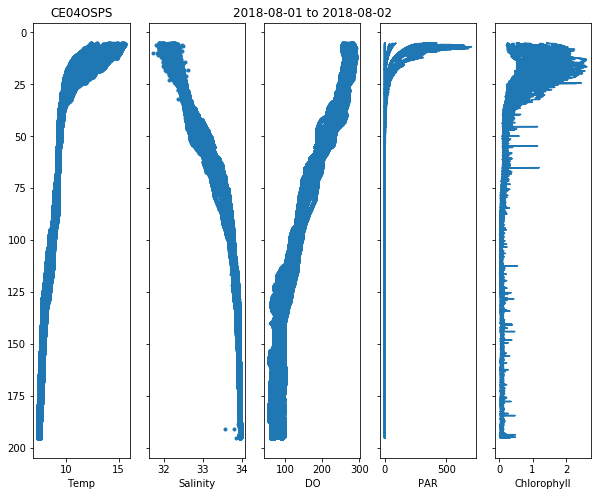

In [17]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, sharex=False, sharey=True)
fig.set_size_inches(10,8)

ax1.plot(data_do.seawater_temperature,data_do.seawater_pressure,'.')
ax2.plot(data_do.practical_salinity,data_do.seawater_pressure,'.')
ax3.plot(data_do.corrected_dissolved_oxygen,data_do.seawater_pressure,'.')
ax4.plot(data_par.par_counts_output,data_par.int_ctd_pressure)
ax5.plot(data_flo.fluorometric_chlorophyll_a,data_flo.int_ctd_pressure)

ax1.invert_yaxis()

ax1.set_xlabel('Temp')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('DO')
ax4.set_xlabel('PAR')
ax5.set_xlabel('Chlorophyll')

ax1.set_title(data_do.subsite);
ax3.set_title('%s to %s' % (np.datetime_as_string(data_do.time.min().values,unit='D'),
                            np.datetime_as_string(data_do.time.max().values,unit='D')));
plt.savefig('%s.png' % (data_do.subsite))

## CP02PMUO Pioneer Upstream Offshore Profiler Mooring (452m)

In [0]:
# Data Requests
# request_data('CP02PMUO-WFP01-02-DOFSTK000','recovered_wfp','dofst_k_wfp_instrument_recovered','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')
# request_data('CP02PMUO-WFP01-05-PARADK000','recovered_wfp','parad_k__stc_imodem_instrument_recovered','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')
# request_data('CP02PMUO-WFP01-04-FLORTK000','recovered_wfp','flort_sample','2018-08-01T00:00:00.000Z','2018-08-03T00:00:00.000Z')


In [0]:
# 2-Days
url_cp02_do = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T204755-CP02PMUO-WFP01-02-DOFSTK000-recovered_wfp-dofst_k_wfp_instrument_recovered/catalog.html'
url_cp02_par = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T205026-CP02PMUO-WFP01-05-PARADK000-recovered_wfp-parad_k__stc_imodem_instrument_recovered/catalog.html'
url_cp02_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T205035-CP02PMUO-WFP01-04-FLORTK000-recovered_wfp-flort_sample/catalog.html'


In [0]:
data_do = get_data(url_cp02_do,'CTDPF')
data_par = get_data(url_cp02_par,'CTDPF')
data_flo = get_data(url_cp02_flo,'CTDPF')

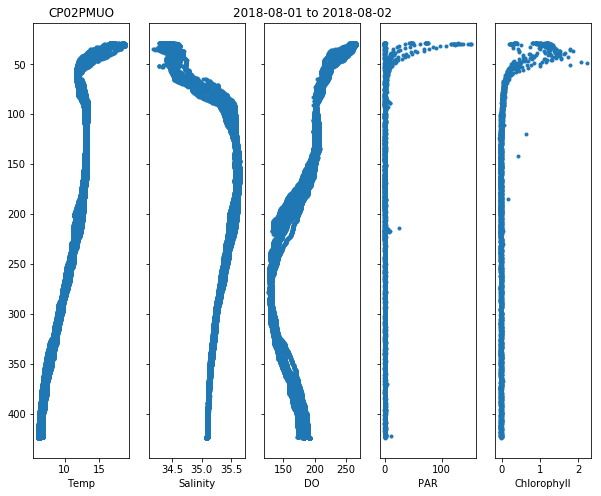

In [20]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, sharex=False, sharey=True)
fig.set_size_inches(10,8)

ax1.plot(data_do.ctdpf_ckl_seawater_temperature,data_do.int_ctd_pressure,'.')
ax2.plot(data_do.practical_salinity,data_do.int_ctd_pressure,'.')
ax3.plot(data_do.dofst_k_oxygen_l2,data_do.int_ctd_pressure,'.')
ax4.plot(data_par.parad_k_par,data_par.int_ctd_pressure,'.')
ax5.plot(data_flo.fluorometric_chlorophyll_a,data_flo.int_ctd_pressure,'.')

ax1.invert_yaxis()

ax1.set_xlabel('Temp')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('DO')
ax4.set_xlabel('PAR')
ax5.set_xlabel('Chlorophyll')

ax1.set_title(data_do.subsite);
ax3.set_title('%s to %s' % (np.datetime_as_string(data_do.time.min().values,unit='D'),
                            np.datetime_as_string(data_do.time.max().values,unit='D')));
plt.savefig('%s.png' % (data_do.subsite))

## CP02PMCO Full Timeseries

In [0]:
url_cp02_do = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T170152-CP02PMCO-WFP01-02-DOFSTK000-recovered_wfp-dofst_k_wfp_instrument_recovered/catalog.html'
# url_cp02_par = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T173403-CP02PMCO-WFP01-05-PARADK000-recovered_wfp-parad_k__stc_imodem_instrument_recovered/catalog.html'
# url_cp02_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190507T173411-CP02PMCO-WFP01-04-FLORTK000-recovered_wfp-flort_sample/catalog.html'

In [22]:
data_do = get_data(url_cp02_do,'CTDPF')
data_do = data_do[['int_ctd_pressure','ctdpf_ckl_seawater_temperature','practical_salinity','dofst_k_oxygen_l2']].to_dataframe()
data_do = data_do[1::5] # Subsample

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 660 times more chunks
  return self.array[key]


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


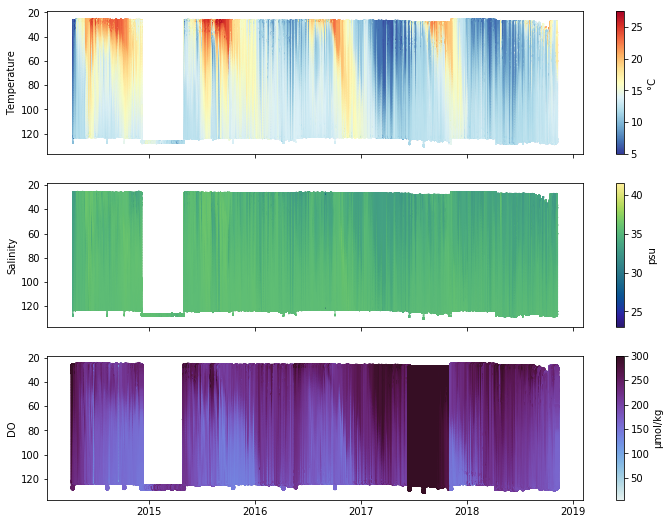

In [23]:
# Plot the data
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True, sharey=True)
fig.set_size_inches(12, 9)

a1 = ax1.scatter(data_do.index, data_do.int_ctd_pressure, c=data_do.ctdpf_ckl_seawater_temperature, marker=".", s=1, cmap='RdYlBu_r')
a2 = ax2.scatter(data_do.index, data_do.int_ctd_pressure, c=data_do.practical_salinity, marker=".", s=1, cmap=cmocean.cm.haline) #vmin=32, vmax=34,
a3 = ax3.scatter(data_do.index, data_do.int_ctd_pressure, c=data_do.dofst_k_oxygen_l2, marker=".",vmax=300,cmap=cmocean.cm.dense) # s=1, vmin=0, 

cb1 = plt.colorbar(a1,ax=ax1)
cb2 = plt.colorbar(a2,ax=ax2) #extend='both'
cb3 = plt.colorbar(a3,ax=ax3) #extend='max'
cb1.set_label('°C')
cb2.set_label('psu')
cb3.set_label('µmol/kg')

ax1.set_ylabel("Temperature")
ax2.set_ylabel("Salinity")
ax3.set_ylabel("DO")

ax1.invert_yaxis()
# ax1.set_xlim(min(ctd_data.index),max(ctd_data.index));

# ax1.set_title('%s-%s-%s'%(ds.subsite,ds.node,ds.sensor));

# xlim_min = datetime.datetime(2015, 12, 1, 0, 0)
# xlim_max = datetime.datetime(2016, 12, 1, 0, 0)
# ax1.set_xlim(xlim_min,xlim_max)

plt.savefig("CP02PMCO_full.png")

